In [5]:
    ## Sequential model
    #Trained on IMDB dataset 
    #https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, Dense
from keras.regularizers import l1
import pickle
import tensorflow as tf
from sklearn.utils import class_weight
import re
from nltk.tokenize import word_tokenize

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



max_words = 15000  # Maximum number of unique words to consider
max_sequence_length = 250  # Maximum length of each
embedding_dim = 300  # Dimension of the GloVe word embeddings
negation_words = ['not', 'no', 'never']  # Words to be considered as negation words


Num GPUs Available:  1


In [2]:
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coeffs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coeffs
    return embeddings_index


def create_embedding_matrix(embeddings_index, word_index, embedding_dim):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix


def sentiment_to_binary(sentiment):
    if sentiment == 'positive':
        return 1
    else:
        return 0



def preprocess_text_with_negation(text):
    # Convert the text to lowercase
    text = text.lower()

    # for negation_word in negation_words:
    #     if negation_word in text:
    #         text = text.replace(negation_word, 'not_')

    # Remove any non-alphanumeric characters
    text = ''.join(char for char in text if char.isalnum() or char.isspace())
    
    return text



In [6]:
df1= pd.read_csv('../IMDB Dataset.csv')

In [7]:
df2 = pd.read_csv('../Reviews.csv')

In [8]:
df2 = df2[['Text', 'Score']]
df2 = df2.rename(columns={'Text': 'review', 'Score': 'sentiment'})
df2['sentiment'] = df2['sentiment'].apply(lambda x: 'positive' if x > 3 else 'negative')

In [9]:
df = pd.concat([df1, df2], ignore_index=True)


In [10]:
# Apply the preprocess_text_with_negation function to the 'review' column
df['review'] = df['review'].apply(preprocess_text_with_negation)

df['sentiment'] = df['sentiment'].apply(sentiment_to_binary)


In [11]:
df.head()

,review,sentiment
0,not good moive,0
1,i absolutely loved this movie the plot was eng...,1
2,what a disappointment the storyline was weak a...,0
3,the cinematography in this film was breathtaki...,1
4,i struggled to stay awake during this movie th...,0


In [12]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42)

In [13]:
# Tokenize the text
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [14]:
# Convert the text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)


In [15]:

# Pad the sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)

In [16]:


embeddings_index = load_glove_embeddings('../glove.42B.300d.txt')
embedding_matrix = create_embedding_matrix(embeddings_index, word_index, embedding_dim)

In [17]:
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, TimeDistributed

model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=True))
model.add(SpatialDropout1D(0.2))

# Adding a 1D convolutional layer
# model.add(Conv1D(128, 3, activation='relu', padding='same'))
# model.add(MaxPooling1D(pool_size=2))

model.add(Bidirectional(LSTM(100, dropout=0.0, recurrent_dropout=0.0, kernel_regularizer=l1(0.001), return_sequences=True)))

# Adding a TimeDistributed layer to apply a dense layer to each of the outputs of the LSTM layer
    

model.add(TimeDistributed(Dense(25, activation='relu')))

# Adding a GlobalMaxPooling1D layer to reduce the output to a single vector
model.add(GlobalMaxPooling1D())

# Adding a dense layer before the final output layer
model.add(Dense(25, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 300)          96429900  
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 300)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 250, 200)         320800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 250, 25)          5025      
 ibuted)                                                         
                                                                 
 global_max_pooling1d (Globa  (None, 25)               0         
 lMaxPooling1D)                                         

In [19]:
sample_weights = class_weight.compute_sample_weight('balanced', y_train)


In [20]:
# Train the model
print('Training the model...')
with open('new_tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

model.fit(X_train_padded, y_train, epochs=2, batch_size=64, validation_data=(X_test_padded, y_test), sample_weight=sample_weights)


model.save('sentiment_analysis_model4_.h5')

Training the model...
Epoch 1/2
7732/7732 [==============================] - 583s 75ms/step - loss: 0.4571 - accuracy: 0.8636 - val_loss: 0.3713 - val_accuracy: 0.8846
Epoch 2/2
7732/7732 [==============================] - 601s 78ms/step - loss: 0.3299 - accuracy: 0.9010 - val_loss: 0.3070 - val_accuracy: 0.9122


In [21]:
scores = model.evaluate(X_test_padded, y_test, verbose=0)

print("Accuracy: %.2f%%" % (scores[1] * 100))
# Save the trained model


Accuracy: 91.21%


In [18]:
# Load the trained model
from keras.models import load_model
model = load_model('sentiment_analysis_model4_.h5')

# Generate predictions for the test data
y_pred = model.predict(X_test_padded)

# Convert the predicted probabilities to class labels
y_pred_classes = (y_pred > 0.5).astype(int).reshape(-1)

# Compare the predicted labels with the true labels and calculate metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test, y_pred_classes))
print(confusion_matrix(y_test, y_pred_classes))
print("Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred_classes) * 100))


3866/3866 [==============================] - 42s 10ms/step
              precision    recall  f1-score   support

           0       0.78      0.89      0.83     29901
           1       0.96      0.92      0.94     93807

    accuracy                           0.91    123708
   macro avg       0.87      0.91      0.89    123708
weighted avg       0.92      0.91      0.91    123708

[[26757  3144]
 [ 7727 86080]]
Accuracy: 91.21%


3866/3866 [==============================] - 39s 10ms/step


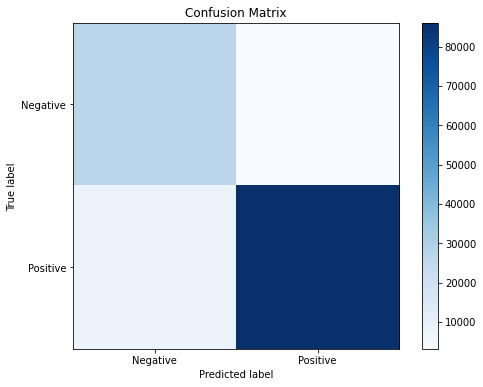

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_roc_curve

# Predict on test data
y_pred = model.predict(X_test_padded)
y_pred_binary = (y_pred > 0.5).astype(int)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
plt.show()




In [23]:

# model = load_model('sentiment_analysis_model4_.h5')

# Maximum length of each sequence
max_sequence_length = 250
negation_words = ['not', 'no', 'never']  # Words to be considered as negation words

# Words to be considered as negation words
def preprocess_text_with_negation(text):
    # Convert the text to lowercase
    text = text.lower()
    
    # Replace any negation words with "not_" to preserve their meaning in the model
    # Remove any non-alphanumeric characters
    text = ''.join(char for char in text if char.isalnum() or char.isspace())
    
    return text

# Function to convert user input to a padded sequence of fixed length
def preprocess_input(input_text, tokenizer):
    input_text = preprocess_text_with_negation(input_text)
    input_sequence = tokenizer.texts_to_sequences([input_text])
    input_padded = pad_sequences(input_sequence, maxlen=max_sequence_length)
    return input_padded

# Function to predict the sentiment of the user input
def predict_sentiment(input_text, tokenizer, model):
    input_padded = preprocess_input(input_text, tokenizer)
    prediction = model.predict(input_padded)[0][0]
    print(prediction)
    if prediction >= 0.5:
        return 'positive'
    else:
        return 'negative'

# Load the Tokenizer used during training
tokenizer = pickle.load(open('new_tokenizer.pkl', 'rb'))

# Get user input
user_input = input('Enter a statement: ')

#while loop to keep asking for input
while user_input != 'exit':
    # Predict the sentiment of the user input
    prediction = predict_sentiment(user_input, tokenizer, model)

    print(f'The sentiment of the statement "{user_input}" is {prediction}.')
    user_input = input('Enter a statement: ')
    
# # Predict the sentiment of the user input
# prediction = predict_sentiment(user_input, tokenizer, model)

# print(f'The sentiment of the statement "{user_input}" is {prediction}.')

1/1 [==============================] - 0s 29ms/step
0.18849337
The sentiment of the statement "not ogod" is negative.
1/1 [==============================] - 0s 34ms/step
0.7999423
The sentiment of the statement "good" is positive.
1/1 [==============================] - 0s 25ms/step
0.08932252
The sentiment of the statement "not amazing" is negative.
1/1 [==============================] - 0s 31ms/step
0.2898316
The sentiment of the statement "bad" is negative.
1/1 [==============================] - 0s 31ms/step
0.16832913
The sentiment of the statement "really bad" is negative.
1/1 [==============================] - 0s 45ms/step
0.8836868
The sentiment of the statement "amazing" is positive.


In [1]:
#To continue training the model

model = load_model('../sentiment_analysis_model2.h5')

checkpoint_filepath = 'sentiment_analysis_model_checkpoint{epoch:02d}.h5'

checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_data=(X_test_padded, y_test), callbacks=[checkpoint])

model.save('sentiment_analysis_model2.1.h5')

NameError: name 'load_model' is not defined